In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/train.csv


## References

This notebook was written with heavy guidance from the CNN tutorial published by Dr. Yassine Ghouzam (link below).
Some changes were made throughout, but the structure and many variables follow the tutorial closely.
The objective for me in reconstructing this was for my own education.

https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6



In [19]:
#Library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='dark', context='notebook', palette='deep')

## Importing and Initial Data Analsis

To start off, we'll get the data into two different pandas dataframes, and take a quick glance at them.

In [20]:
#Importing the datasets

train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test =  pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

print(train.head())
print(train.shape)
print(train.describe())
print(test.head())
print(test.shape)
print(test.describe())

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

As seen above, these are datasets of pixels by image, with each row representing a seperate image of 784 pixels (likely 28 high X 28 wide).  The training set contains 42000 images, while the testing set contains 28000.  Becuase these are monochromatic pictures, if a pixel has a value of 0 it is black, and if it has a value of 255 it's white; grey falls between those values.  Were they not black and white, we could expect three different sets of values for each pixel, representing red, green, and blue.

The training set has an extra column relating to the actual digit drawn for each image (the labels).  Going forward, that is going to be very important information but we need to seperate it out so we only have pixel data in the training set.  Below, the labels are sectioned off into their own list, and the corrisponding column is dropped from the training set.

In [21]:
#Makes a list of the actual digits drawn for each image, then get's rid of that column from the training set
labels = train["label"]
train = train.drop(columns = 'label')


Now, let's take a look at the prevelance of each of the digits.

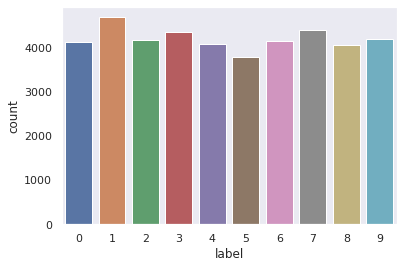

In [22]:
#Making counts for each of the digits.  There are similar amounts, which is expected
sns.countplot(labels)

As shown above, while some digits happen a few hundred times more often than others (which is unlikely to be due to random chance), they aren't so unevenly represented that the model would encounter significant problems with any particular digit.





I trust Kaggle and MINST do pretty good jobs keeping their data intact, but we'll double check there aren't any missing values within the datasets (below).

In [23]:
#Looks for null values (errors in datasets).
print(train.isnull().values.any())
print(test.isnull().values.any())

False
False


No null (missing) values in either of them

## Data Transformation

Now we need to get the datasets ready for use.  We'll start with putting all of the pixel values on a 0-1 scale instead of the standard 0-255.  This is easily acomplished below.

In [24]:
#Puts pixel intensity (usualy 0 - 255) onto a 0 - 1 scale
train /= 255.0
test /= 255.0

Next, we'll actualy want to put each picture into a more realistic dimension; right now we have a single dimension containing 784 values for each image.  For these pictures, we want dimensions  28 X 28 X 1.  The third dimension pretains to the channel (color type); for this we only have one color type (black/white).  Were these colored images we could expect three layers, one for red, green, and blue.

In [25]:
#Turns each row of pixels into a 28 X 28 X 1, 3D matrix; more like actual pictures.
train = train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In addition, The list of lables should be transformed into a series of one-hot vectors, which are basically lists with dummy variables or each of the digits.  This is nessicary for comparing our predicted values to their true values.  

In [26]:
#Changes the lables into vectors of dummy variables
labels = to_categorical(labels, num_classes = 10)

Now, a very important step: splitting off a validation data set.

Our model isn't going to be very good at learning if it doesn't get any feedback on how it's doing.  Each time the model runs through it will need to be put to the test in order to see what it's doing right, and what it's doing wrong; that's what the validation set is for.  It will help the model tune it's different hidden parameters to come up with more reliable results. 
We can't just use the training set for it, as then the model may overfit to the training data and be innefective at predicting results on any new data.  
I.e., You can study the answers to the test, but you won't get the fundamental understanding nessicary to perform well if the answers change.

Note: becuase we use the same validation set for the training, the peformance will still be overstated (somewhat overfitted).  The test set is a more true indicator of how the model actually performs, but we won't be able to use that until the model has fully trained, and then only as an indicator of performance.

In [27]:
#Splits part of the training set off into a validation set
val_size = 0.15 #The portion of the training set that will become the validation set.  15% is a fairly standard size, although the predetermined testing set for this is larger than usual in comparison.
train, validation, train_labels, validation_labels = train_test_split(train, labels, test_size = val_size)

## Building the Model

Below, we construct the actual model.  The structure of the model is taken directly from the tutorial (referenced at the beginning of this notebook).
I've annoted each of the parts within, describing the functionallity of all the layers.

In [28]:
#Pretty much took this directly from the tutorial, although the annotations are origional (compiled from many sources)

#Initializes a sequential model.  Good for one input (image) and one output(a classification).  Allows us to add layers
model = Sequential() 

#Adds the first layer.  This is a convolutional layer with 32 filters, and kernal sizes of 5 by 5.  
#This uses ReLU as an activation function, which rounds all negative values to 0.  It's a minimally computational intensive way to break up linearity.
#'Same' padding means it will 'pad' the edges of the feature map with 0s, so the map stays the same size
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))

#Adds the second layer, same as the first.
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))

#MaxPool2D is a downsampling layer, which will get rid of some of the fine details by returning the maximum value for each 2 by 2 set of pixels (non overlaping).  This makes the model more resiliant to overitting, and to small changes in the input images (shifting, rotating, cropping, etc)
#In effect, as the poolsize is 2 by 2, this will shrink the dimensions of the feature map by 2; the number of pixels will be quartered.  This will result in a 14 X 14 (196 pixel) map.
#An alternative would be average pooling, which takes the average of the pool instead of the max.  
model.add(MaxPool2D(pool_size=(2,2)))

#Dropout gets rid of a proportion of the nodes in each sample.  Distributes learning more effectively across all nodes, and helps avoid overfitting.
model.add(Dropout(0.25))

#Adds a 4th layer, another convolutional layer with a kernal size of 3 by 3 and 64 filters
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))

#Adds a 5th layer, same as above
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))

#Another pooling (downsampling) layer
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

#Drops more of the nodes
model.add(Dropout(0.25))

#A flattening layer that converts the maps into a 1 dimensional vector, which is nessicary for classification
model.add(Flatten())

#Adds a Dense layer, which is just a layer of neurons each connected to all previous neurons.  Also applies ReLU
model.add(Dense(256, activation = "relu"))

#More dropout
model.add(Dropout(0.5))

#A final Dense layer of neurons.  However, this uses 'softmax' activation.  This will output a vector size of 10 of the probabilities (summing to 1) of an image corrisponding to each potential classification.  The max of that is basically our prediction for an image.
model.add(Dense(10, activation = "softmax"))

Now, we need an optomizer function to actually improve the model as it iterates through.  It's objective is to continually shrink the loss (error rate) as the model progresses.
This will be what actually adjusts each of the hidden parameters within the model after it has a chance to compare the results to the validation set.  
This again was taken directly from the tutorial.

In [29]:
#RMSprop is an adjusted Adagrad optomizer.  Adagrad changes the learning rate for each of the parameters.  
#RMSprop keeps a moving average of estimated squared gradient, instead of a growing one like Adagrad, allowing for a faster learning time.
optimizer = RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0)

#Applies the optomizer.  Categorical Crossentropy makes it so the loss function (how the model performs) considers more than 2 classes (we have 10).  
#The metric 'accuracy' is bascially a loss function for which the results are not used for traing the model.
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

The learning rate is the size of the step the weights move opposite the gradient each cycle.  High rates mean gradient decent can miss the minimum or diverge, and low rates take forever to run.
This method will continually drop the learning rate as it runs
The parameters for this were set by the tutorial author to reduce the learning rate by half every 3 epochs if the accuracy has since not improved.

In [30]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)



Below is data augmentation.  It will make small changes to the training data in order to increase the amount of training data.  
It will make the model more generalizeable and greatly reduce overfitting but providing additonal images with slight transformations.  These include adding images with cropping, zooming, rotating, etc.
This was also taken directly from the tutorial, including the notes on each parameter

In [31]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

#Need to fit the ImageDataGenerator object to the data so it has the information it needs to perform augmentations
datagen.fit(train)



## Running the Model

Now it's time to actually run the thing.  

First we need to set some parameters: namely the epoch and the batch size.  The epoch is basiclly how many run-throughs the model will do.  More is generally better, but takes longer.

After than, the model actually runs.


Note on training time: the more epochs, the longer it takes (and more accurate it gets)
Using GPUs will help speed it up significantly (reccomended)

In [32]:
#Parameters for the model
epochs = 40 
batch_size = 86

#.flow() method is used on a data generator and creates an iterator of batches of augmented data according to the batch size
#A note on .fit() vs .fit_generator(): both methods fit (train) data to the model.  
#.fit() assumes no data augmentation (raw data only) and a small enough sample size to fit into RAM.  Should use for small and simple datasets.
#.fit_generator() assumes we use data augmentation; that each batch of data is being augmented (changing).  It will take a batch of data, perform backpropagation, update the weights, and repeat for all epochs.

history = model.fit_generator(datagen.flow(train,train_labels, batch_size=batch_size),
                              epochs = epochs, validation_data = (validation,validation_labels),
                              verbose = 2, steps_per_epoch=train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/40
415/415 - 12s - loss: 0.5114 - accuracy: 0.8341 - val_loss: 0.0787 - val_accuracy: 0.9770 - lr: 5.0000e-04
Epoch 2/40
415/415 - 11s - loss: 0.1709 - accuracy: 0.9497 - val_loss: 0.0717 - val_accuracy: 0.9767 - lr: 5.0000e-04
Epoch 3/40
415/415 - 11s - loss: 0.1187 - accuracy: 0.9653 - val_loss: 0.0396 - val_accuracy: 0.9875 - lr: 5.0000e-04
Epoch 4/40
415/415 - 11s - loss: 0.0972 - accuracy: 0.9712 - val_loss: 0.0362 - val_accuracy: 0.9894 - lr: 5.0000e-04
Epoch 5/40
415/415 - 11s - loss: 0.0834 - accuracy: 0.9749 - val_loss: 0.0437 - val_accuracy: 0.9865 - lr: 5.0000e-04
Epoch 6/40
415/415 - 12s - loss: 0.0761 - accuracy: 0.9768 - val_loss: 0.0313 - val_accuracy: 0.9903 - lr: 5.0000e-04
Epoch 7/40
415/415 - 11s - loss: 0.0696 - accuracy: 0.9798 - val_loss: 0.0341 - val_accuracy: 0.9900 - lr: 5.0000e-04
Epoch 8/40
415/415 - 11s - loss: 0.0629 - accuracy: 0.9810 - val_loss: 0.0261 - val_accuracy: 0.9925 - lr: 5.0000e-04
Epoch 9/40
415/415 - 11s - loss: 0.0612 - accuracy: 0.98

## Discussion

Now we want to take a look at how the training went.  Below, we print out the training history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


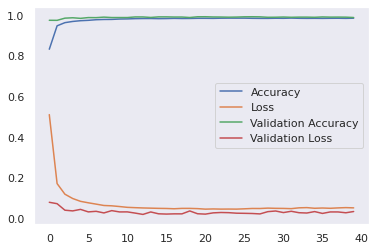

In [33]:

print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.legend(['Accuracy', 'Loss', "Validation Accuracy", "Validation Loss"])


As one can see, it started off fairly accurate and got more-so, peaking around 10 epochs or so.  
Also, becuase the validation accuracy is not less than the accuracy, we can infer that the model is not over fitting to the training data


Now, we should make a confusion matrix to see where the errors in our model are.  To do that, we need to first make class predictions (one predictions, not arrays of probabilities).  Ordinarily, we would use the testing data here, but Kaggle doesn't include the answer key for it (for obious reasons).  So for the purposes of demonstrating the errors here, we can examine our validation data in a confusion matrix.  In reality, the model likely won't be so accurate, but it should be close.

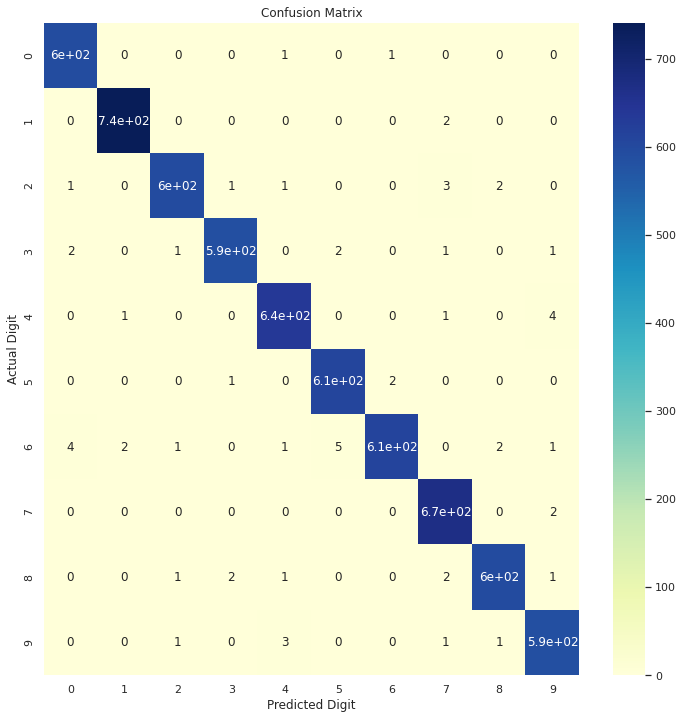

In [34]:
#Makes predictions on the validation set
validation_predictions = model.predict_classes(validation)

#Makes the confusion matrix
#argmax is going to change the one-hot validation labels into categorical (single digit) lables
confmat = confusion_matrix(validation_predictions,np.argmax(validation_labels, axis=1))


plt.figure(figsize = [12,12])
sns.heatmap(confmat, annot = True, cmap=plt.cm.YlGnBu)
plt.ylabel('Actual Digit')
plt.xlabel('Predicted Digit')
plt.title('Confusion Matrix')
plt.show()

Above, you can see that most predictions lign up with the labels (the actual digits the pictures represent).  There are a few incorrect predictions, but the vast majority are correct.  I don't see any particular patterns as to if any numbers are more likely to be falsely predicted than others.

Below, we run predictions on the test set, and output them for submission.

In [53]:
#Makes class predictions on the test set
predictions = model.predict_classes(test)

#Makes an index for the submission
index = list(range(len(test)))
index = [x+1 for x in index]

#Outputs the submission
output = pd.DataFrame({'ImageID': index, 'Label': predictions})
output.to_csv('predictions.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


Again, I would like to reiterate that this this notebook was written with heavy guidance from the tutorial published by Dr. Yassine Ghouzam (link below).

I've made some changes throughout, along with the annotations, but the structure and many variables follow the tutorial closely.

https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

